<a href="https://colab.research.google.com/github/jjain0811/Categorical-Crime-Rate-Analysis-and-Prediction/blob/main/Category_California.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade keras-hypetune
!pip install prettytable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 5.3 MB/s 
  Attempting uninstall: hyperopt
    Found existing installation: hyperopt 0.1.2
    Uninstalling hyperopt-0.1.2:
      Successfully uninstalled hyperopt-0.1.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasRandomSearch, KerasGridSearch
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.rcParams.update({'font.size': 15})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
### READ DATA ###

# df = pd.read_csv('https://docs.google.com/spreadsheets/d/18UOUY4S-iFNxwdwHsNupFunhzgvkql1udtY4_KlBI0w/export?format=csv&gid=1787086033')

# column_matter = 'Murder'
# df.drop(['Victim Families and Children','The National Stolen Property Act of 1934'],axis=1,inplace=True)

# column_matter = 'Victim Families and Children'
# df.drop(['Murder','The National Stolen Property Act of 1934'],axis=1,inplace=True)

# column_matter = 'The National Stolen Property Act of 1934'
# df.drop(['Victim Families and Children','Murder'],axis=1,inplace=True)

df = pd.read_csv('https://docs.google.com/spreadsheets/d/1diq5R_nTdc59vcwEtoaw3wMPJYAVlO7s0Pnc4PbBAek/export?format=csv&gid=0') # California Data
column_matter = 'Crime Rate'

df.dropna(axis=1, inplace=True, how='all')
df.dropna(inplace=True)
# df[column_matter] = [int(float(a.replace(",",""))) for a in df[column_matter]] # Comment for california, Victim and Act
# df["Population"] = [int(float(a.replace(",",""))) for a in df["Population"]] # Comment for california
df["Tourism"] = [int(float(a.replace(",",""))) for a in df["Tourism"]]
df[column_matter] = df[column_matter]*100/df['Population'] # *100 for state, /10 for act and victim
print(df.columns)
df.tail()

Index(['Population', 'Unemployment Rate', 'Annual GDP Growth', 'Inflation',
       'Tourism', 'Poverty', 'Crime Rate'],
      dtype='object')


,Population,Unemployment Rate,Annual GDP Growth,Inflation,Tourism,Poverty,Crime Rate
57,39399349,4.841667,2.3,2.1,231123000000,1.7,3.212388
58,39461588,4.275000,2.9,1.9,237726000000,1.7,3.340585
59,39512223,4.150000,2.3,2.3,233461000000,1.7,3.025507
60,39538223,10.216667,-3.4,1.4,220339154216,1.8,3.218764
61,39377453,7.708333,5.7,7.0,232720205417,1.8,2.920044


In [ ]:
### ADJUST AND CLEAN DATA ###
n_attr = 8
n_tres = 7
df_external = pd.DataFrame(df.index)

for col in df.columns:

    # if df[col].dtype == object: # correct type
    #     df[col] = pd.to_numeric(df[col].str.replace(',', '.'))

    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans

    if col in ['T','RH','AH']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

Population : 0.0
Unemployment Rate : 0.0
Annual GDP Growth : 0.0
Inflation : 0.0
Tourism : 0.0
Poverty : 0.0
Crime Rate : 0.0


In [ ]:
### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):

    for col in cols:

        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())

    return data

In [ ]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###

df = cycle_encode(df,['Tourism','Population'])
df.drop(['Tourism','Population'],axis=1,inplace=True)
n_attr = 10
n_tres = 9
df.head(15)

# df_external['month'] = df_external.date.dt.month
# df_external['day'] = df_external.date.dt.dayofweek
# df_external['hour'] = df_external.date.dt.hour

# df_external = cycle_encode(df_external, ['month','day','hour'])
# df_external.drop(['month','day','hour'], axis=1, inplace=True)
# df_external.set_index('date', inplace=True)

# print(df_external.shape)
# df_external.head()

,Unemployment Rate,Annual GDP Growth,Inflation,Poverty,Crime Rate,Tourism_sin,Tourism_cos,Population_sin,Population_cos
0,6.6,2.6,1.4,0.9,3.474339,-0.974048,-0.226341,0.600324,-0.799757
1,6.0,2.6,0.7,0.8,3.410148,-0.839751,-0.542972,0.510595,-0.859821
2,5.5,6.1,1.3,0.8,3.560972,-0.451629,-0.892206,0.430294,-0.902689
3,5.5,4.4,1.6,0.9,3.786970,-0.531200,-0.847246,0.339412,-0.940638
4,5.0,5.8,1.0,0.9,4.139881,-0.059780,-0.998212,0.264599,-0.964359
5,4.0,6.5,1.9,0.9,4.319358,0.070456,-0.997515,0.184409,-0.982850
6,3.8,6.6,3.5,0.9,4.549434,-0.043741,-0.999043,0.134842,-0.990867
7,3.8,2.7,3.0,0.9,5.055098,-0.252852,-0.967505,0.097753,-0.995211
8,3.4,4.9,4.7,1.0,5.721118,-0.115248,-0.993337,0.086993,-0.996209
9,3.5,3.1,6.2,1.0,6.099681,-0.446035,-0.895015,0.051801,-0.998657


In [ ]:
### SPLIT TRAIN TEST ###

train, test = train_test_split(df, shuffle=False, train_size=0.8)
train_ext, test_ext = train_test_split(df_external, shuffle=False, train_size=0.8)

print(train.shape, test.shape)
print(train_ext.shape, test_ext.shape)

(49, 9) (13, 9)
(49, 1) (13, 1)


In [ ]:
### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):

    plt.figure(figsize=(16,4))

    plt.plot(train.index, train[name], label='train')
    plt.plot(test.index, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()

def plot_autocor(name, df):

    plt.figure(figsize=(16,4))

    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()

    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

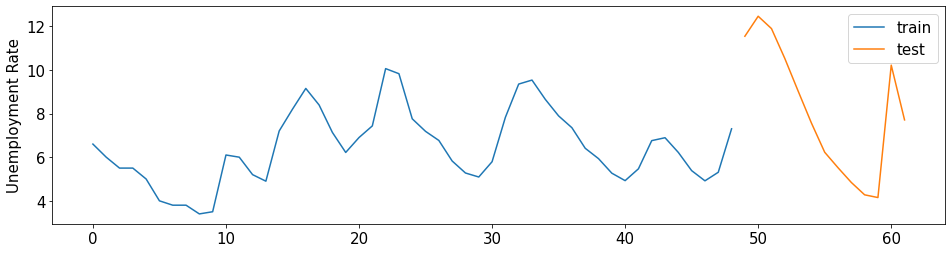

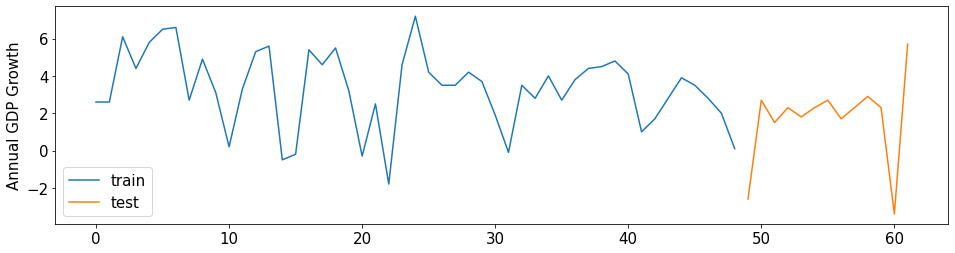

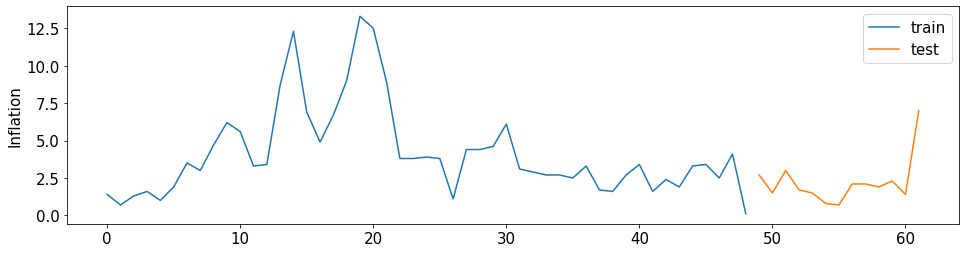

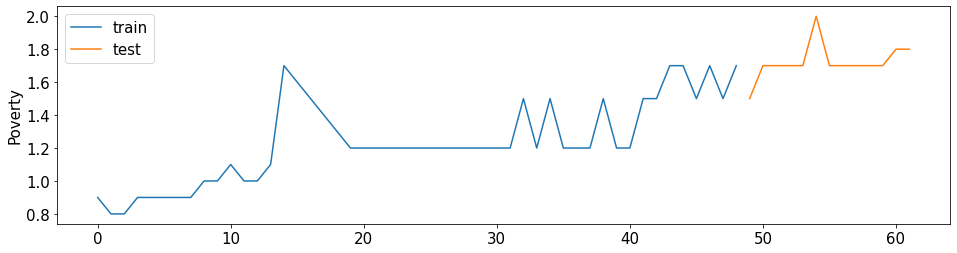

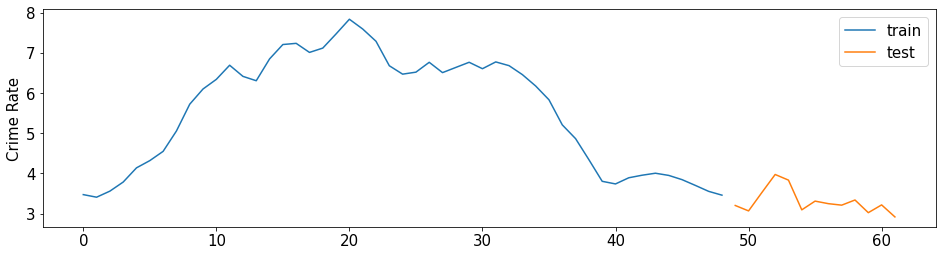

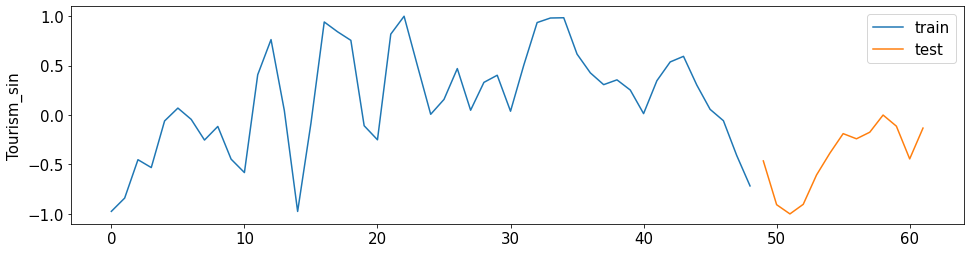

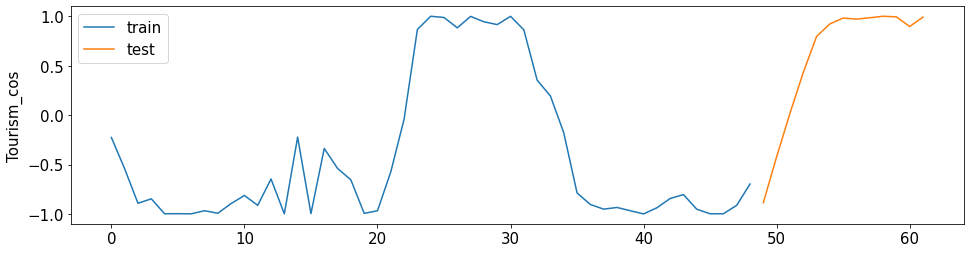

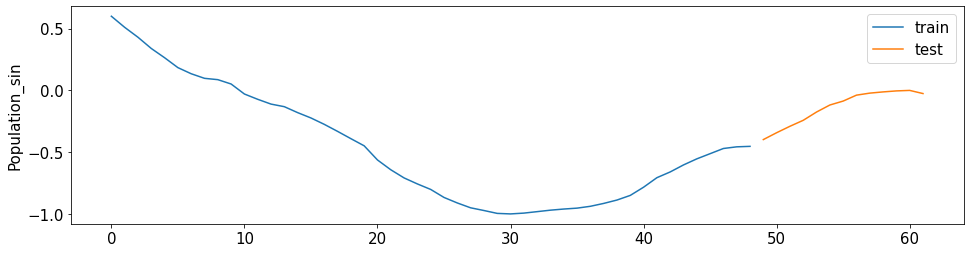

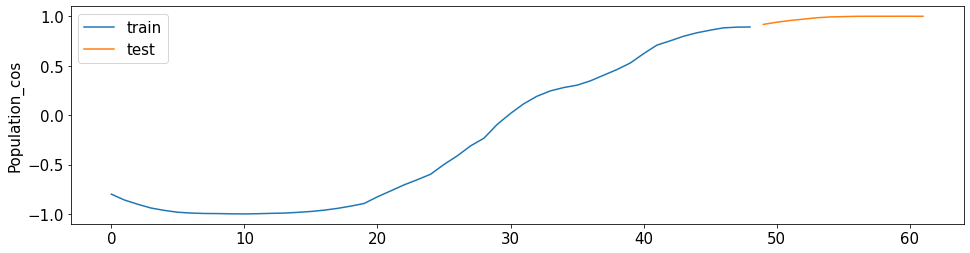

In [ ]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


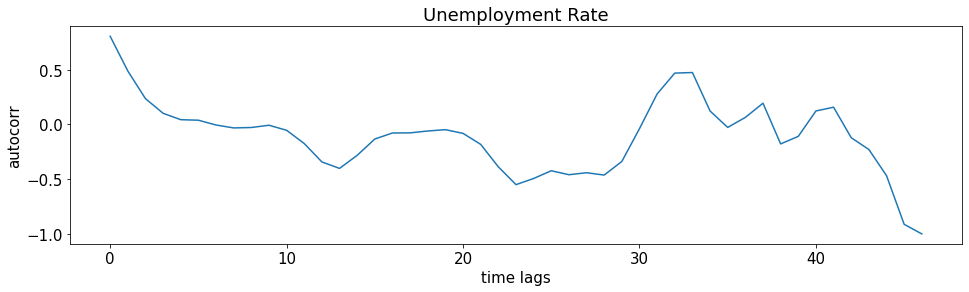

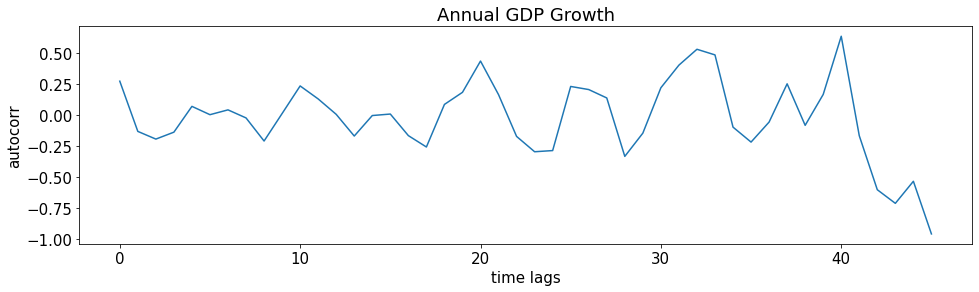

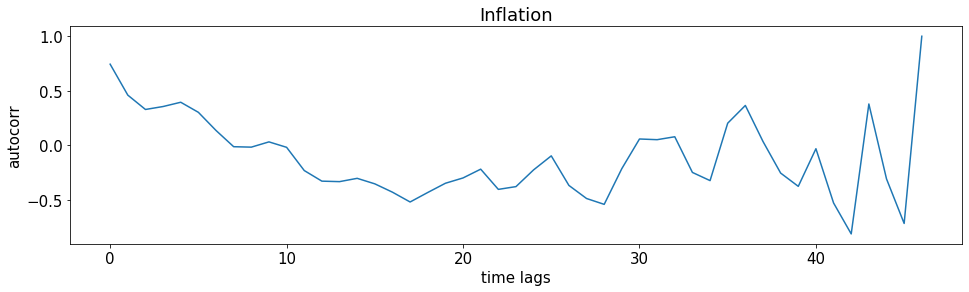

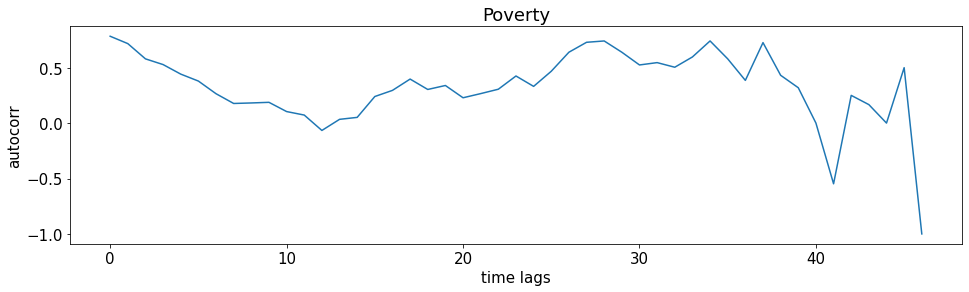

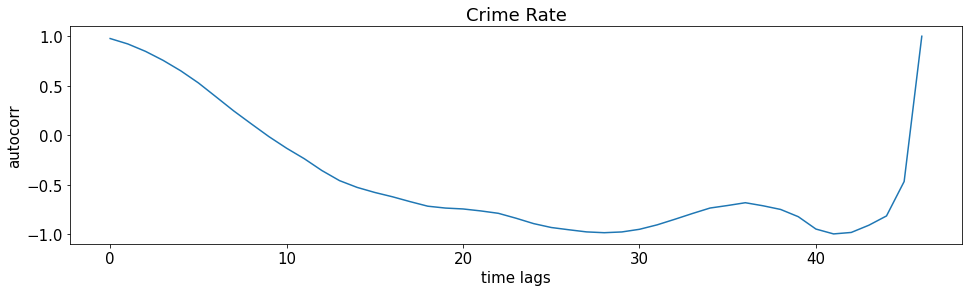

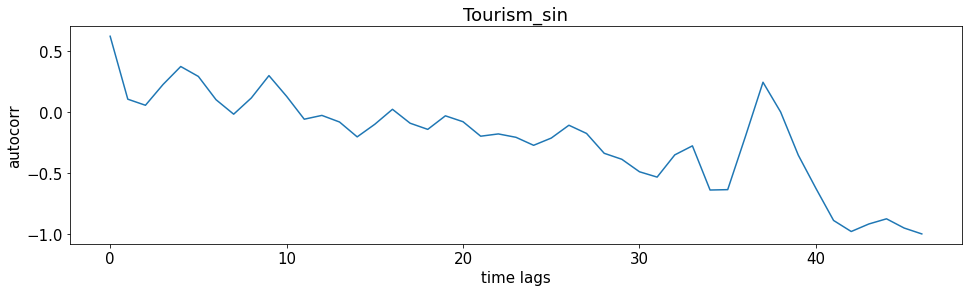

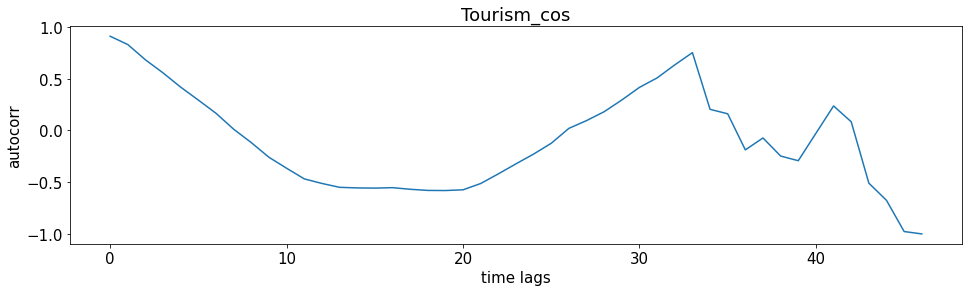

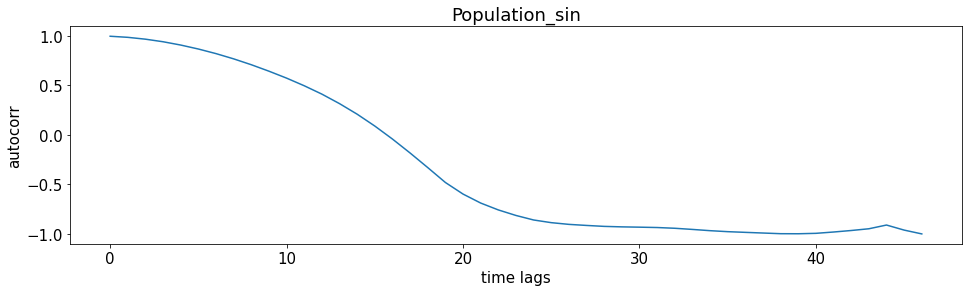

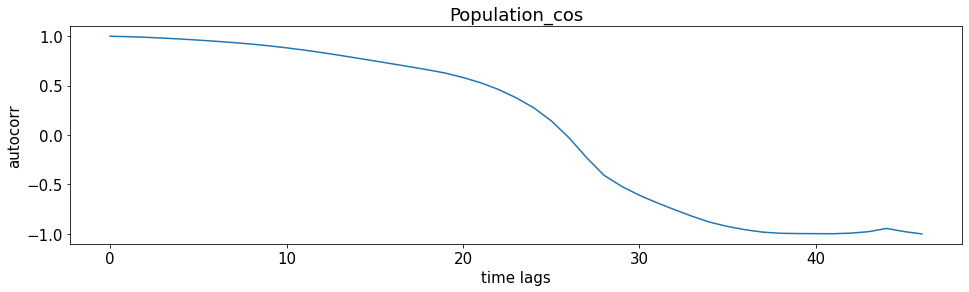

In [ ]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [ ]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0
for i in tqdm(range(1,3)):
    model = VAR(endog=train.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic

    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i

print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

100%|██████████| 2/2 [00:00<00:00, 107.28it/s]

BEST ORDER: 2 BEST AIC: -30.318343374523362


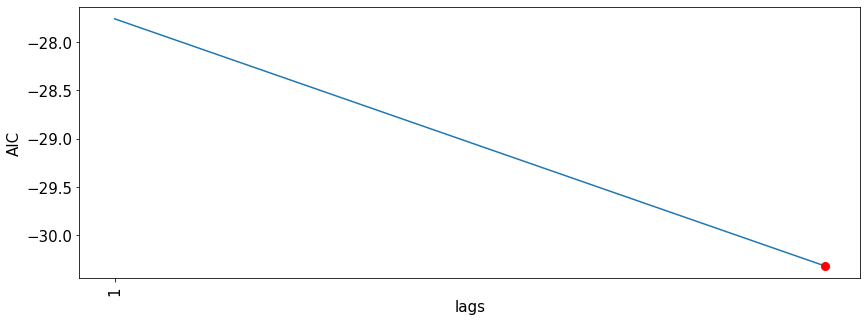

In [ ]:
### PLOT AICs ###

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(0,len(AIC), 2), range(1,100, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [ ]:
### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

-30.318343374523362

# COMBINE VAR AND LSTM

In [ ]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###


def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):

    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data

    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id

    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1

    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))

    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)

    return np.squeeze(window_data, 1)


def set_seed(seed):

    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param, look_ahead, look_back):

    set_seed(33)

    opt = Adam()
    opt.lr = param['lr']

    inp = Input(shape=(look_back, n_attr))

    x = LSTM(param['units_lstm'], activation='tanh')(inp)
    x = RepeatVector(look_ahead)(x)
    x = LSTM(param['units_lstm'], activation='tanh', return_sequences=True)(x)
    out = TimeDistributed(Dense(n_tres))(x)

    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')

    return model


def get_model_finetune(param, kgs, look_ahead, look_back):

    set_seed(33)

    best_model_config = get_model(kgs.best_params, look_ahead, look_back)
    best_model_config.set_weights(kgs.best_model.get_weights())

    best_model_config.optimizer.lr = param['lr']

    return best_model_config

In [ ]:
### DEFINE GRIDS FOR HYPERPARAM TUNING ###

param_grid = {
    'units_lstm': [256, 128, 96],
    'lr': [7e-4, 1e-3, 3e-3],
    'epochs': 200,
    'batch_size': [512, 1024]
}

param_grid_finetune = {
    'lr': stats.loguniform(1e-5, 0.025),
    'epochs': 200,
}

In [ ]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

y_train = train.iloc[best_order:].values
y_train_var = var_result.fittedvalues

X_train = np.concatenate([
    train.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([
    var_result.fittedvalues, train_ext.iloc[best_order:].values], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, shuffle=False, train_size=0.8)
X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(
    X_train_var, y_train_var, shuffle=False, train_size=0.8)

y_test = test.values
X_test = np.concatenate([test.values, test_ext.values], axis=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(37, 10) (10, 10) (13, 10)
(37, 10) (10, 10)
(37, 9) (10, 9) (13, 9)
(37, 9) (10, 9)


In [ ]:
### SCALE DATA ###

scaler = StandardScaler()
scaler_y = StandardScaler()
scaler_var = StandardScaler()
scaler_y_var = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

y_train_var = scaler_y_var.fit_transform(y_train_var)
y_val_var = scaler_y_var.transform(y_val_var)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_fut_pred = X_test
X_train_var = scaler_var.fit_transform(X_train_var)
X_val_var = scaler_var.transform(X_val_var)

In [ ]:
### BUILD DATA GENERATOR ###

look_back = 3
look_ahead = 6

X_train = create_windows(X_train, window_shape = look_back, end_id = -look_ahead)
y_train = create_windows(y_train, window_shape = look_ahead, start_id = look_back)
X_train_var = create_windows(X_train_var, window_shape = look_back, end_id = -look_ahead)
y_train_var = create_windows(y_train_var, window_shape = look_ahead, start_id = look_back)

X_val = create_windows(X_val, window_shape = look_back, end_id = -look_ahead)
y_val = create_windows(y_val, window_shape = look_ahead, start_id = look_back)
X_val_var = create_windows(X_val_var, window_shape = look_back, end_id = -look_ahead)
y_val_var = create_windows(y_val_var, window_shape = look_ahead, start_id = look_back)
X_fut = X_test
X_test = create_windows(X_test, window_shape = look_back, end_id = -look_ahead)
y_test = create_windows(y_test, window_shape = look_ahead, start_id = look_back)

X_fut_pred = create_windows(X_fut[4:], window_shape = look_back, end_id = -look_ahead)
print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(29, 3, 10) (2, 3, 10) (5, 3, 10)
(29, 3, 10) (2, 3, 10)
(29, 6, 9) (2, 6, 9) (5, 6, 9)
(29, 6, 9) (2, 6, 9)


In [ ]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)

kgs_var = KerasGridSearch(hypermodel, param_grid,
                          monitor='val_loss', greater_is_better=False, tuner_verbose=1)

kgs_var.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 256, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.58183 at epoch 13

***** (2/18) *****
Search({'units_lstm': 256, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.58183 at epoch 13

***** (3/18) *****
Search({'units_lstm': 256, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 1.52979 at epoch 4

***** (4/18) *****
Search({'units_lstm': 256, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.52979 at epoch 4

***** (5/18) *****
Search({'units_lstm': 256, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 1.56326 at epoch 10

***** (6/18) *****
Search({'units_lstm': 256, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.56326 at epoch 10

***** (7/18) *****
Search({'units_lstm': 96, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.38866 at epoch 34

***** (8/18) *****
Search({'units_lstm': 96, 'lr': 0.0007, 'epochs': 200,

In [ ]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES (AFTER THE TRAIN ON VAR FITTED VALUES) ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model_finetune(param=x, kgs=kgs_var, look_ahead=look_ahead, look_back=look_back)

krs_ft = KerasRandomSearch(hypermodel, param_grid_finetune, n_iter=20, sampling_seed=33,
                           monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_ft.search(X_train, y_train, batch_size=kgs_var.best_params['batch_size'],
              validation_data=(X_val, y_val), callbacks=[es])


20 trials detected for ('lr', 'epochs')

***** (1/20) *****
Search({'lr': 0.0003857635118975211, 'epochs': 200})
SCORE: 1.24327 at epoch 1

***** (2/20) *****
Search({'lr': 0.0005714173878534292, 'epochs': 200})
SCORE: 1.25077 at epoch 1

***** (3/20) *****
Search({'lr': 7.740755538615648e-05, 'epochs': 200})
SCORE: 1.23093 at epoch 1

***** (4/20) *****
Search({'lr': 0.0016506606834983432, 'epochs': 200})
SCORE: 1.29531 at epoch 1

***** (5/20) *****
Search({'lr': 0.0028975199561219536, 'epochs': 200})
SCORE: 1.34772 at epoch 1

***** (6/20) *****
Search({'lr': 7.456687844809637e-05, 'epochs': 200})
SCORE: 1.23082 at epoch 1

***** (7/20) *****
Search({'lr': 0.0009501006290131641, 'epochs': 200})
SCORE: 1.26625 at epoch 1

***** (8/20) *****
Search({'lr': 1.8215739071153037e-05, 'epochs': 200})
SCORE: 1.22858 at epoch 1

***** (9/20) *****
Search({'lr': 3.052974383613633e-05, 'epochs': 200})
SCORE: 1.22907 at epoch 1

***** (10/20) *****
Search({'lr': 9.772977050450925e-05, 'epochs':

In [ ]:
### OBTAIN PREDICTIONS AND RETRIVE ORIGINAL DATA ###

pred_lstm_var = krs_ft.best_model.predict(X_test)
pred_lstm_var = scaler_y.inverse_transform(pred_lstm_var.reshape(-1, pred_lstm_var.shape[-1])).reshape(pred_lstm_var.shape)

In [ ]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)

kgs = KerasGridSearch(hypermodel, param_grid,
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 256, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.58183 at epoch 13

***** (2/18) *****
Search({'units_lstm': 256, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.58183 at epoch 13

***** (3/18) *****
Search({'units_lstm': 256, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 1.52979 at epoch 4

***** (4/18) *****
Search({'units_lstm': 256, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.52979 at epoch 4

***** (5/18) *****
Search({'units_lstm': 256, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 1.56326 at epoch 10

***** (6/18) *****
Search({'units_lstm': 256, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 1.56326 at epoch 10

***** (7/18) *****
Search({'units_lstm': 96, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 1.38866 at epoch 34

***** (8/18) *****
Search({'units_lstm': 96, 'lr': 0.0007, 'epochs': 200,

In [ ]:
X_test

array([[[ 3., -3., -1.,  2., -3., -1., -1.,  0.,  3.,  3.],
        [ 3., -0., -1.,  2., -3., -2., -0.,  0.,  3.,  3.],
        [ 3., -1., -1.,  2., -2., -2.,  0.,  0.,  3.,  3.]],

       [[ 3., -0., -1.,  2., -3., -2., -0.,  0.,  3.,  3.],
        [ 3., -1., -1.,  2., -2., -2.,  0.,  0.,  3.,  3.],
        [ 2., -1., -1.,  2., -2., -2.,  1.,  0.,  3.,  3.]],

       [[ 3., -1., -1.,  2., -2., -2.,  0.,  0.,  3.,  3.],
        [ 2., -1., -1.,  2., -2., -2.,  1.,  0.,  3.,  3.],
        [ 1., -1., -1.,  2., -2., -2.,  1.,  1.,  3.,  3.]],

       [[ 2., -1., -1.,  2., -2., -2.,  1.,  0.,  3.,  3.],
        [ 1., -1., -1.,  2., -2., -2.,  1.,  1.,  3.,  3.],
        [ 1., -1., -1.,  4., -3., -1.,  2.,  1.,  3.,  3.]],

       [[ 1., -1., -1.,  2., -2., -2.,  1.,  1.,  3.,  3.],
        [ 1., -1., -1.,  4., -3., -1.,  2.,  1.,  3.,  3.],
        [-0., -0., -1.,  2., -3., -1.,  2.,  1.,  3.,  3.]]])

In [ ]:
### OBTAIN PREDICTIONS ###

pred_lstm = kgs.best_model.predict(X_test)
pred_lstm = scaler_y.inverse_transform(pred_lstm.reshape(-1, pred_lstm.shape[-1])).reshape(pred_lstm.shape)

In [ ]:
### COMPUTE METRICS ON TEST DATA ###

error_lstm, error_var_lstm = {}, {}
error_baseline = {}
y1,y2,y3= [],[],[]
for i,col in enumerate(df.columns):
  error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
  error_lstm[col] = error
  error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
  error_var_lstm[col] = error
  if col==column_matter:
    kr = True
    for a,b,c in zip(y_test[...,i],pred_lstm[...,i],pred_lstm_var[...,i]):
      if kr:
        y1.extend(a)
        y2.extend(b)
        y3.extend(c)
        kr = False
      else:
        y1.append(a[-1])
        y2.append(b[-1])
        y3.append(c[-1])
y1,y2,y3

([3.974773287430028,
  3.834485000322523,
  3.095862525881753,
  3.3128147604473925,
  3.249314264210358,
  3.2123881031638364,
  3.34058528004499,
  3.0255068159541416,
  3.2187637770164836,
  2.920044117632494],
 [5.958154,
  5.7124763,
  5.4742465,
  5.2580385,
  5.071219,
  4.9156327,
  4.8697476,
  4.77684,
  4.714155,
  4.6415386],
 [5.9643655,
  5.3667455,
  4.820161,
  4.5266886,
  4.4390874,
  4.454269,
  4.6417165,
  4.5825334,
  4.594654,
  4.5877314])

In [ ]:
myTable = PrettyTable(["Attribute", "Combined Model Error", "LSTM Error"])
for a in error_lstm:
  myTable.add_row([a,error_var_lstm[a],error_lstm[a]])
print(myTable)

+-------------------+----------------------+--------------------+
|     Attribute     | Combined Model Error |     LSTM Error     |
+-------------------+----------------------+--------------------+
| Unemployment Rate |  4.199222137957762   | 5.035851188281079  |
| Annual GDP Growth |  4.693873921178013   |  4.17287006203453  |
|     Inflation     |  4.012748544286398   | 3.9168555433060845 |
|      Poverty      | 0.23702297475815823  | 0.2055555410305893 |
|     Crime Rate    |  3.4667158011438963  | 4.241204879372211  |
|    Tourism_sin    |  0.5503191862003495  | 0.5115471729362818 |
|    Tourism_cos    |  4.4880586034855945  | 2.0361054743330733 |
|   Population_sin  | 0.47113289362742283  | 0.4994714484434522 |
|   Population_cos  | 0.46162303678783384  | 0.6501464970925818 |
+-------------------+----------------------+--------------------+


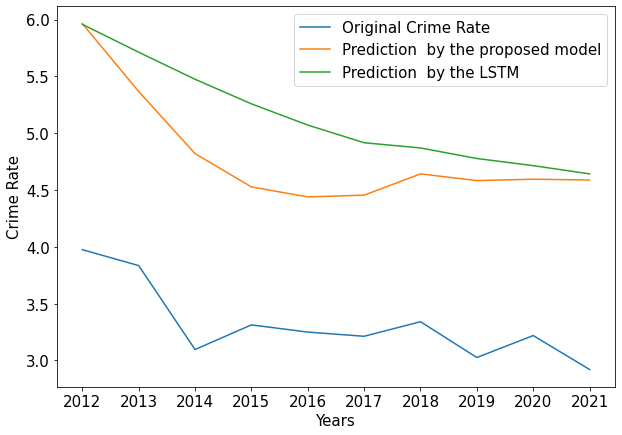

In [ ]:
y = [i for i in range(2012,2022)]
plt.figure(figsize=(10, 7))
plt.plot(y,y1, label = "Original Crime Rate")
plt.plot(y,y3, label = "Prediction  by the proposed model")
plt.plot(y,y2, label = "Prediction  by the LSTM")
plt.xlabel("Years")
plt.ylabel("Crime Rate")
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.legend()
plt.show()

In [ ]:
last_pred = y3[-1]
fut_pred = krs_ft.best_model.predict(X_fut_pred)
fut_prediction = []
for i,col in enumerate(df.columns):
  if col==column_matter:
    kr = True
    for a in fut_pred[...,i]:
      if kr:
        fut_prediction.extend(a)
        kr = False
      else:
        fut_prediction.append(a[-1])
print("Prediction for the years after 2022: ",[last_pred+a for a in fut_prediction])

Prediction for the years after 2022:  [4.571205, 4.124742, 3.6255474, 3.3108537, 3.187896, 3.163039]


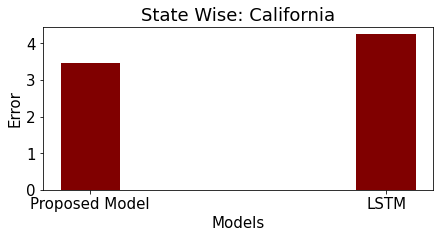

In [ ]:
victim_wise = [3.46, 4.24]
models = ['Proposed Model','LSTM']
fig = plt.figure(figsize = (7, 3))
plt.bar(models, victim_wise, color ='maroon', width = 0.2)
plt.xlabel("Models")
plt.ylabel("Error")
plt.title("State Wise: California")
plt.show()